In [1]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download puneet6060/intel-image-classification

! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
import keras

from sklearn.metrics import confusion_matrix, classification_report
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [4]:
trainpath = '/content/seg_train/'
testpath = '/content/seg_test/'
predpath = '/content/seg_pred/'

In [5]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) :
    for x , y in code.items() : 
        if n == y : 
            return x 

In [6]:
size = 150

In [7]:
X_train = []
y_train = []
for folder in  os.listdir('/content/seg_train/seg_train') : 
    files = gb.glob(pathname= str( '/content/seg_train/seg_train//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (size,size))
        X_train.append(list(image_array))
        y_train.append(code[folder])

In [8]:
X_test = []
y_test = []
for folder in  os.listdir('/content/seg_test/seg_test') : 
    files = gb.glob(pathname= str('/content/seg_test/seg_test//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (size,size))
        X_test.append(list(image_array))
        y_test.append(code[folder])
        

In [9]:
X_pred = []
files = gb.glob(pathname= str('/content/seg_pred/seg_pred/*.jpg'))
for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (size,size))
    X_pred.append(list(image_array)) 

In [11]:
train_augmantation = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
train_data = train_augmantation.flow_from_directory('/content/seg_train/seg_train/', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=True)

Found 14034 images belonging to 6 classes.


In [12]:
validation_augmantation = ImageDataGenerator(rescale=1.0/255)
validation_data = validation_augmantation.flow_from_directory('/content/seg_test/seg_test/', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=True)

Found 3000 images belonging to 6 classes.


In [13]:
labels = {value: key for key, value in train_data.class_indices.items()}

In [14]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid', activation = 'relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation = 'relu', kernel_regularizer=l2(0.00005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation = 'relu', kernel_regularizer=l2(0.00005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax'))


In [15]:
print('Model Details are : ')
print(model.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                   

In [16]:
# Is used to reduce the learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [17]:
opt = Adam(learning_rate=0.001)

In [18]:
model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [19]:
history = model.fit(train_data, epochs=50, validation_data=validation_data, callbacks=[reduce_lr])

Epoch 1/50
439/439 [==============================] - 99s 205ms/step - loss: 2.0532 - accuracy: 0.4939 - val_loss: 1.5672 - val_accuracy: 0.5203 - lr: 0.0010
Epoch 2/50
439/439 [==============================] - 87s 197ms/step - loss: 1.0915 - accuracy: 0.6093 - val_loss: 0.9187 - val_accuracy: 0.6577 - lr: 0.0010
Epoch 3/50
439/439 [==============================] - 85s 194ms/step - loss: 0.9292 - accuracy: 0.6573 - val_loss: 1.0551 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 4/50
439/439 [==============================] - 86s 195ms/step - loss: 0.8558 - accuracy: 0.6879 - val_loss: 0.7699 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 5/50
439/439 [==============================] - 85s 194ms/step - loss: 0.8135 - accuracy: 0.7075 - val_loss: 1.9754 - val_accuracy: 0.5127 - lr: 0.0010
Epoch 6/50
439/439 [==============================] - 85s 193ms/step - loss: 0.7661 - accuracy: 0.7277 - val_loss: 0.6228 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 7/50
439/439 [==============================] 

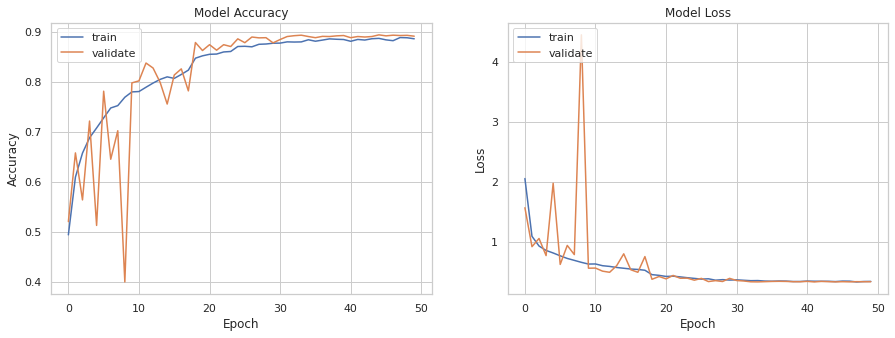

In [22]:
def plotmodelhistory(history):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validate'], loc = 'upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'validate'], loc = 'upper left')
    plt.show()

plotmodelhistory(history)

In [24]:
test_augmantation = ImageDataGenerator(rescale=1.0/255)

test_data = test_augmantation.flow_from_directory('/content/seg_test/seg_test/',
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (150, 150),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [25]:
predictions = model.predict(test_data)

94/94 [==============================] - 3s 36ms/step


In [26]:
test_loss, test_accuracy = model.evaluate(test_data, batch_size=32)

94/94 [==============================] - 3s 37ms/step - loss: 0.3346 - accuracy: 0.8910


In [27]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.33460885286331177
Test Accuracy: 0.890999972820282


In [29]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

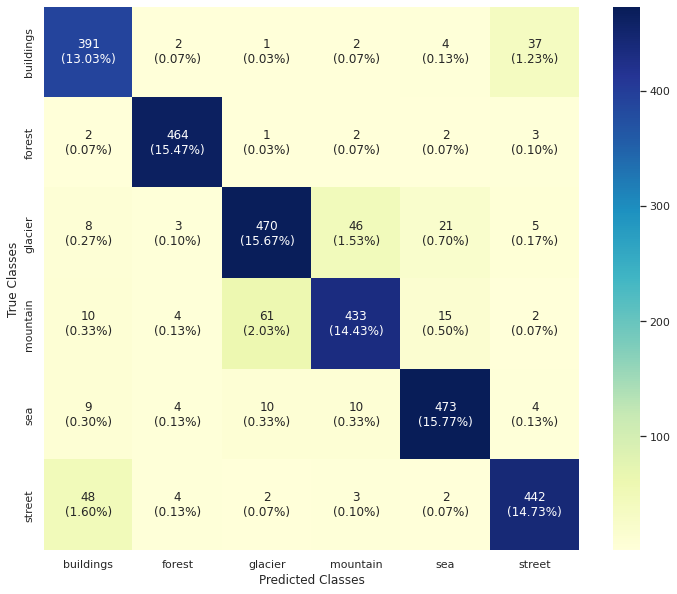

In [30]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [31]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.84      0.89      0.86       437
      forest       0.96      0.98      0.97       474
     glacier       0.86      0.85      0.86       553
    mountain       0.87      0.82      0.85       525
         sea       0.91      0.93      0.92       510
      street       0.90      0.88      0.89       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

